In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [3]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp8d09ma2y


In [306]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700, 500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50,
    "log_events": True,
}

mode = 3
if mode == 1:
    print ("dense")
    current_settings["num_objects"]["friend"] = 50
    current_settings["num_objects"]["enemy"] = 50
elif mode == 2:
    print ("bouncy")
    current_settings["hero_bounces_off_walls"] = True
elif mode == 3:
    print ("short-sighted")
    current_settings["observation_line_length"] = 60.
else:
    print ("normal")
    
# create the game simulator
g = KarpathyGame(current_settings)

short-sighted


In [241]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.ops.reset_default_graph()
    session = tf.InteractiveSession()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [200, 200, g.num_actions], 
                [tf.tanh, tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.0001, decay=0.9)

    # DiscreteDeepQ object
    current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                       discount_rate=0.99, exploration_period=5000, max_experience=30000, 
                                       store_every_nth=2, train_every_nth=2,
                                       target_network_update_rate=0.1,
                                       summary_writer=journalist)
    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)

Exception ignored in: <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f120128e0b8>>
Traceback (most recent call last):
  File "/usr/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 122, in __del__
    self.close()
  File "/usr/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 622, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/lib64/python3.4/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2791, in get_controller
    assert self.stack[-1] is default
AssertionError: 


In [307]:
class GreedyController(object):
    def __init__(self):
        pass
    
    def action(self, observation, exploration=False):
        rays = [range(-4,4), range(4, 12), range(12, 20), range(20, 28)]
        res = []
        
        new_shape = (observation[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
        observation = observation[:-2].reshape(new_shape)

        for i, ray in enumerate(rays):
            score = 0
            for r in ray:
                if observation[r][0] < 0.99:
                    score += 1
                elif observation[r][1] < 0.99:
                    score -= 1
            res.append(score)
        return np.argmax(res)

    def training_step(self, *args, **kwargs):
        pass
    
    def store(self, *args, **kwargs):
        pass
current_controller = GreedyController()

In [308]:
FPS          = 30
ACTION_EVERY = 3
    
fast_mode = True
training  = False
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 300
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    simulate(simulation=g,
             controller=current_controller,
             fps=FPS,
             visualize_every=VISUALIZE_EVERY,
             action_every=ACTION_EVERY,
             wait=WAIT,
             disable_training=(not training),
             save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

Interrupted


# Average Reward over time

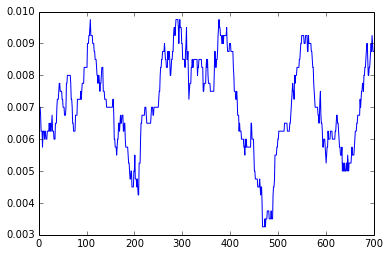

In [183]:
g.plot_reward(smoothing=100)

# Ratio of green to red objects over time

2.3285714285714287 3.1875 4.725


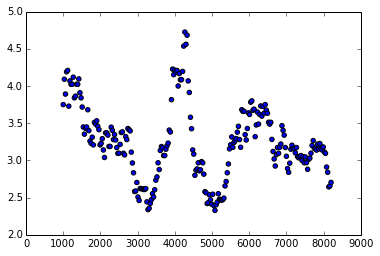

In [309]:
LOOK_BACK = 1000
DT = 30

END_TIME = int(max(e[0] for e in g.events))
graphX = list(range(LOOK_BACK, END_TIME, DT))
graphY = []

aux = []

left_idx, right_idx = 0, 0
collected = {'friend': 1, 'enemy': 1}
for t in graphX:
    while right_idx < len(g.events) and g.events[right_idx][0] < t:
        event = g.events[right_idx][1]
        right_idx += 1
        if event[0] == 'ATE':
            collected[event[1]] += 1
    while left_idx < right_idx and g.events[left_idx][0] < (t - LOOK_BACK):
        event = g.events[left_idx][1]
        left_idx += 1
        if event[0] == 'ATE':
            collected[event[1]] -= 1
            
            
    graphY.append(collected['friend'] / collected['enemy'])
print(min(graphY), np.median(graphY), max(graphY))
plt.scatter(graphX, graphY)
# plt.savefig("figures/performance_greedy.pdf", bbox_inches='tight')

# Visualizing controller's strategy

In [288]:
from euclid          import Point2
from tf_rl.utils.svg import Line

DX, DY = 15, 15
im = g.to_html(silent=True, hero=False)


old_position = g.hero.position

for x in range(5, g.size[0] - 5, DX):
    for y in range(5, g.size[1] - 5, DY):
        g.hero.position = Point2(x,y)
        a = current_controller.action(g.observe(), exploration=False)
        arrow_start = Point2(x ,y) + Point2(13,13)
        arrow_end   = arrow_start + g.directions[a] * 1.
        im.prepend(Line(arrow_start, arrow_end, arrow=True))
g.hero.position = old_position
# with open("figures/strategy_greedy.svg", "wt") as f:
#     im.write_svg(f)
im

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [273]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-2].reshape(new_shape))
print(x[-2:])
g.to_html()

[[1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 0.56 0.00 0.00]
 [1.00 1.00 0.29 0.00 0.00]
 [1.00 1.00 0.20 0.00 0.00]
 [1.00 1.00 0.16 0.00 0.00]
 [1.00 1.00 0.13 0.00 0.00]
 [1.00 1.00 0.12 0.00 0.00]
 [1.00 1.00 0.11 0.00 0.00]
 [1.00 1.00 0.11 0.00 0.00]
 [1.00 1.00 0.11 0.00 0.00]
 [1.00 1.00 0.12 0.00 0.00]
 [1.00 1.00 0.13 0.00 0.00]
 [1.00 1.00 0.16 0.00 0.00]
 [1.00 1.00 0.20 0.00 0.00]
 [1.00 1.00 0.29 0.00 0.00]
 [1.00 1.00 0.56 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.33 1.00 1.00 -0.47 -0.39]
 [0.34 1.00 1.00 -0.47 -0.39]
 [0.41 1.00 1.00 -0.80 -0.97]
 [0.35 1.00 1.00 -0.80 -0.97]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]]
[3.12 -0.80]
